<a href="https://colab.research.google.com/github/yiruchen1993/1st-DL-CVMarathon/blob/feature%2Ffinal_project/D50_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [3]:
import os
import numpy as np
import xml.etree.ElementTree as ET

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/drive/My Drive/study/DL_CV/Final_Project"
os.chdir(path)
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

/content/drive/My Drive/study/DL_CV/Final_Project/keras-yolo3


In [6]:
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [7]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [8]:
if not os.path.exists("raccoon_dataset"):
    !git clone https://github.com/experiencor/raccoon_dataset.git  
else:
    print("raccoon_dataset exists")

raccoon_dataset exists


In [9]:
if not os.path.exists("kangaroo"):
    !git clone https://github.com/experiencor/kangaroo.git  
else:
    print("kangaroo exists")

kangaroo exists


In [10]:
os.getcwd()

'/content/drive/My Drive/study/DL_CV/Final_Project/keras-yolo3'

In [11]:
# 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 
# 當成訓練集 & 驗證集 & 測試集資料
for root, dirs, files in os.walk('raccoon_dataset/images'):
    print('num of raccoon jpg:', len(files))

for root, dirs, files2 in os.walk('kangaroo/images'):
    print('num of kangaroo jpg:', len(files2))

# combine raccoon and kangaroo data
files.extend(files2)
print(len(files))

jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
print(jpg_ids)

num of raccoon jpg: 200
num of kangaroo jpg: 164
364
['raccoon-1', 'raccoon-10', 'raccoon-100', 'raccoon-101', 'raccoon-102', 'raccoon-103', 'raccoon-104', 'raccoon-105', 'raccoon-106', 'raccoon-107', 'raccoon-108', 'raccoon-109', 'raccoon-11', 'raccoon-110', 'raccoon-111', 'raccoon-112', 'raccoon-113', 'raccoon-114', 'raccoon-115', 'raccoon-116', 'raccoon-117', 'raccoon-118', 'raccoon-119', 'raccoon-12', 'raccoon-120', 'raccoon-121', 'raccoon-122', 'raccoon-123', 'raccoon-124', 'raccoon-125', 'raccoon-126', 'raccoon-127', 'raccoon-128', 'raccoon-129', 'raccoon-13', 'raccoon-130', 'raccoon-131', 'raccoon-132', 'raccoon-133', 'raccoon-134', 'raccoon-135', 'raccoon-136', 'raccoon-137', 'raccoon-138', 'raccoon-139', 'raccoon-14', 'raccoon-140', 'raccoon-141', 'raccoon-142', 'raccoon-143', 'raccoon-144', 'raccoon-145', 'raccoon-146', 'raccoon-147', 'raccoon-148', 'raccoon-149', 'raccoon-15', 'raccoon-150', 'raccoon-151', 'raccoon-152', 'raccoon-153', 'raccoon-154', 'raccoon-155', 'raccoon-

In [12]:
sets = ['train', 'val', 'test']
# "raccoon", "kangaroo" 的資料類別
classes = ["raccoon", "kangaroo"]

In [13]:
# print(len(jpg_ids))
np.random.seed(0)
train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.7), replace=False)
print(train_index[0:5])
# print(len(train_index))

non_train = np.setdiff1d(jpg_ids, train_index)
# print(len(non_train))

np.random.seed(0)
val_index = np.random.choice(non_train, size=int(len(non_train)*0.7), replace=False)
print(val_index[0:5])
# print(len(val_index))
test_index = np.setdiff1d(non_train, val_index)
# print(len(test_index))

['00121' '00065' 'raccoon-14' 'raccoon-122' '00022']
['raccoon-28' '00048' 'raccoon-179' '00004' '00099']


In [14]:
is_retrain_new_data = False
if not os.path.exists("train"):

    !mkdir train val test
    # train index
    train_txt = open('train/train.txt', 'w')
    print("save train index at train/train.txt")       
    for train_id in train_index : 
        train_txt.write('%s' %(train_id))
        train_txt.write('\n')
    train_txt.close()

    # val index
    val_txt = open('val/val.txt', 'w')
    print("save val index at val/val.txt")       
    for val_id in val_index : 
        val_txt.write('%s' %(val_id))
        val_txt.write('\n')
    val_txt.close()

    # test index
    test_txt = open('test/test.txt', 'w')
    print("save test index at test/test.txt")       
    for test_id in test_index : 
        test_txt.write('%s' %(test_id))
        test_txt.write('\n')
    test_txt.close()
else:
    print("index data exists")
    is_retrain_new_data = False

print(is_retrain_new_data)

index data exists
False


In [15]:
# save annotation xml
if not os.path.exists("annotation_xml"):
    !mkdir annotation_xml
    !cp raccoon_dataset/annotations/*.xml ./annotation_xml
    !cp kangaroo/annots/*.xml ./annotation_xml
else:
    print("annotation_xml already moved")

annotation_xml already moved


In [16]:
# save class
if not os.path.exists("class.txt"):
    class_txt = open('class.txt', 'w')
        
    for class_id in classes : 
        class_txt.write('%s' %(class_id))
        class_txt.write('\n')
    class_txt.close()
else:
    print("class exists")

class exists


In [17]:
# transform data format
def convert_annotation(image_id, list_file):
    in_file = open('annotation_xml/%s.xml'%(image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1: 
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), 
             int(xmlbox.find('ymin').text), 
             int(xmlbox.find('xmax').text),
             int(xmlbox.find('ymax').text))
        list_file_str = " " + ",".join([str(a) for a in b]) + ',' + str(cls_id)
        list_file.write(list_file_str)

In [18]:
if is_retrain_new_data:
    for image_set in sets:
        image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
        annotation_path = '%s_labels.txt'%(image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        # transform data format
        for image_id in image_ids:
            if 'raccoon' in image_id:
                list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
            else:
                list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
            convert_annotation(image_id, list_file)
            list_file.write('\n')
        list_file.close()
else:
    print("Already converted annotation")

Already converted annotation


In [19]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [20]:
annotation_path = 'train_labels.txt' # 轉換好格式的標註檔案
val_annotation_path = 'val_labels.txt' 
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
num_val = len(val_index)
num_train = len(train_index)

with open(annotation_path) as f:
    lines_train = f.readlines()

with open(val_annotation_path) as f:
    lines_val = f.readlines()















Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    md = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=10,
            initial_epoch=0,
            # callbacks=[checkpoint])
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Train on 254 samples, val on 77 samples, with batch size 16.




Epoch 1/10
15/15 [==============================] - 33s 2s/step - loss: 6112.4404 - val_loss: 2421.3176

Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 1327.1015 - val_loss: 682.8241
Epoch 3/10
15/15 [==============================] - 21s 1s/step - loss: 493.3352 - val_loss: 357.7969
Epoch 4/10
15/15 [==============================] - 8s 537ms/step - loss: 297.1400 - val_loss: 238.0473
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 223.5795 - val_loss: 196.7973
Epoch 6/10
15/15 [==============================] - 22s 1s/step - loss: 184.0107 - val_loss: 165.5635
Epoch 7/10
15/15 [==============================] - 21s 1s/step - loss: 152.3531 - val_loss: 143.8954
Epoch 8/10
15/15 [==============================] - 22s 1s/step - loss: 134.7886 - val_loss: 122.4764
Epoch 9/10
15/15 [==============================] - 22s 1s/step - loss: 116.6903 - val_loss: 103.7490
Epoch 10/1

In [22]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    md2 = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=10,
        initial_epoch=0,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 254 samples, val on 77 samples, with batch size 16.
Epoch 1/10
15/15 [==============================] - 42s 3s/step - loss: 45.7872 - val_loss: 44.0373
Epoch 2/10
15/15 [==============================] - 22s 1s/step - loss: 29.2004 - val_loss: 29.5668
Epoch 3/10
15/15 [==============================] - 25s 2s/step - loss: 25.0915 - val_loss: 25.7036
Epoch 4/10
15/15 [==============================] - 26s 2s/step - loss: 21.9702 - val_loss: 21.9877
Epoch 5/10
15/15 [==============================] - 26s 2s/step - loss: 20.7917 - val_loss: 21.6501
Epoch 6/10
15/15 [==============================] - 25s 2s/step - loss: 20.0723 - val_loss: 21.0723
Epoch 7/10
15/15 [==============================] - 26s 2s/step - loss: 19.1516 - val_loss: 19.0384
Epoch 8/10
15/15 [==============================] - 25s 2s/step - loss: 18.4017 - val_loss: 19.6879
Epoch 9/10
15/15 [==============================] - 26s 2s/step - loss: 17.4369 - val_loss: 18.5060
Epoch 10/10

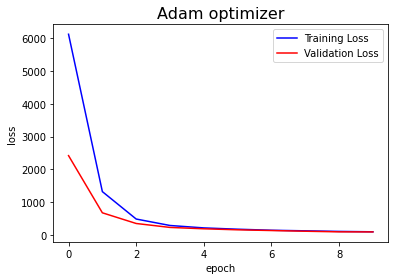

In [23]:
epoch = np.arange(0 , 10)

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , md.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , md.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

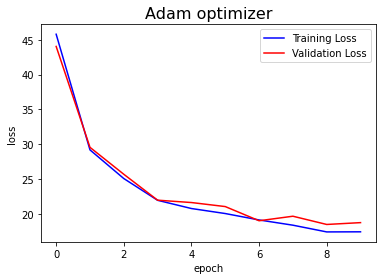

In [24]:
epoch = np.arange(0 , 10)

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , md2.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , md2.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [25]:
# 進行圖片測試
from yolo import YOLO
yolo_model = YOLO(model_path='logs/000/trained_weights_final.h5', classes_path=classes_path)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [26]:
def plot_test_data(image_id):
    if 'raccoon' in image_id:
        test_fig_str = './raccoon_dataset/images/%s.jpg' %(image_id)
    else:
        test_fig_str = './kangaroo/images/%s.jpg' %(image_id)
    print(test_fig_str)
    image = Image.open(test_fig_str)   
    r_image = yolo_model.detect_image(image)
    return r_image 

In [27]:
test_image_ids = open('test/test.txt').read().strip().split()

./kangaroo/images/00047.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (206, 201) (339, 286)
2.658958543999688


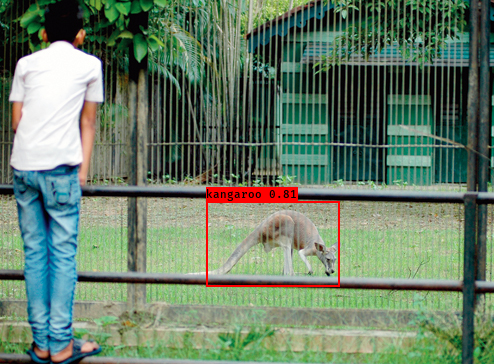

In [28]:
plot_test_data(test_image_ids[0])

./kangaroo/images/00171.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (176, 124) (626, 509)
kangaroo 0.99 (30, 39) (487, 448)
0.08621246199982124


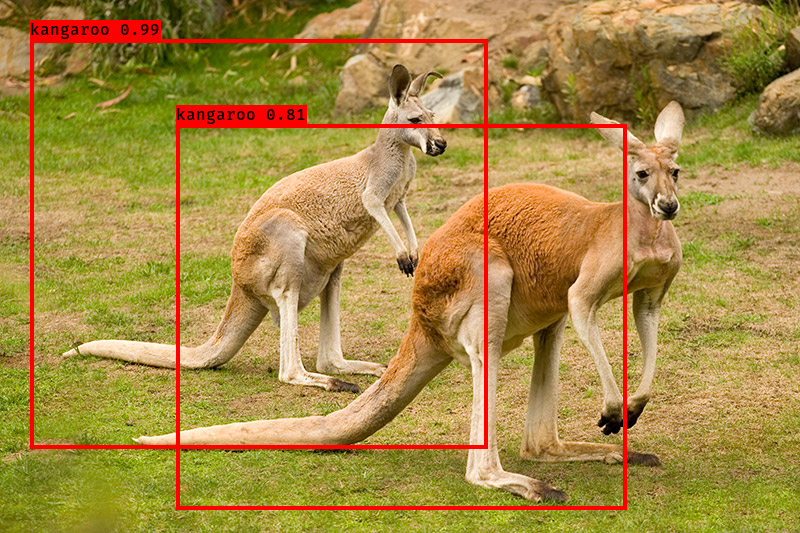

In [29]:
plot_test_data(test_image_ids[10])

./raccoon_dataset/images/raccoon-189.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (82, 12) (490, 424)
0.07299564899949473


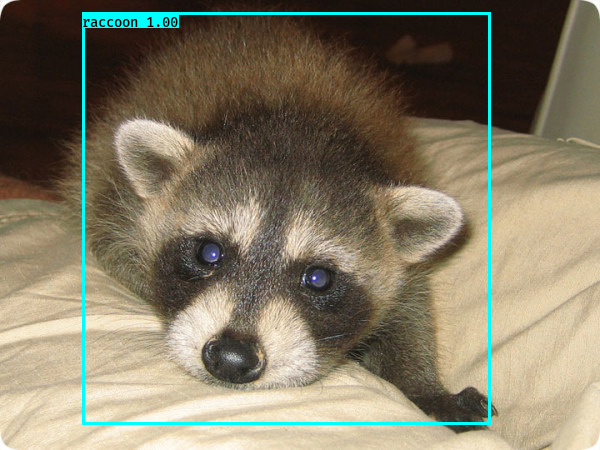

In [30]:
plot_test_data(test_image_ids[20])

./raccoon_dataset/images/raccoon-92.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (142, 33) (622, 569)
0.08194336800079327


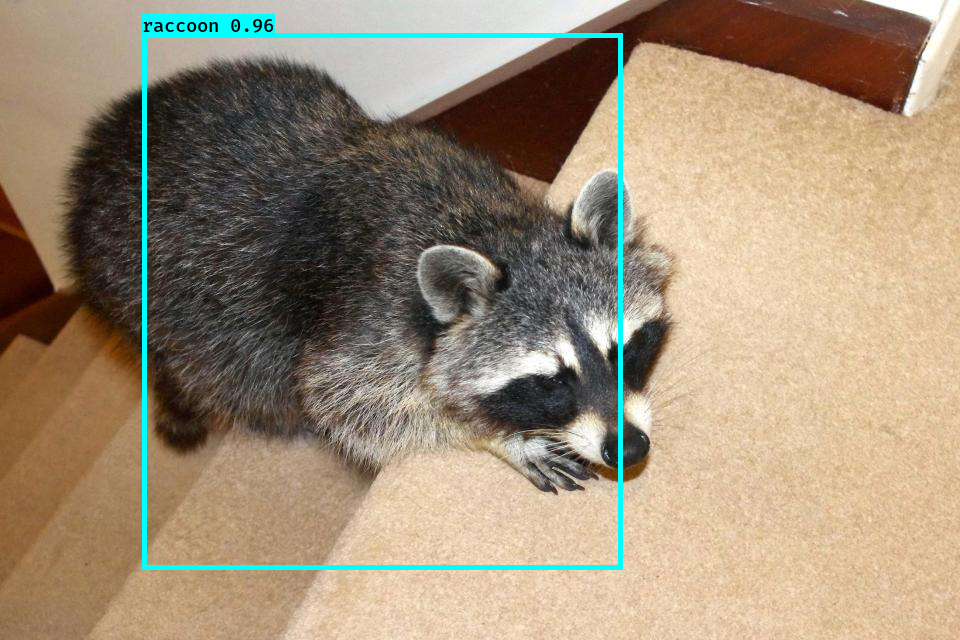

In [31]:
plot_test_data(test_image_ids[30])

./raccoon_dataset/images/raccoon-95.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (56, 86) (262, 301)
0.06916382999952475


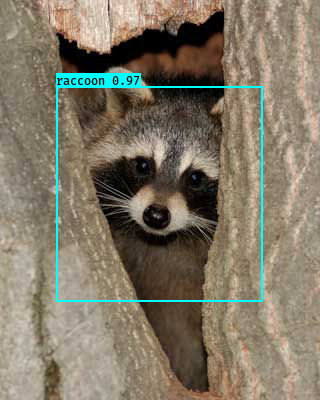

In [32]:
plot_test_data(test_image_ids[32])

In [35]:
import time
import cv2

In [33]:
def detect_video(yolo, video_path, output_path=""):
    # 透過 OpenCV 擷取影像  
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video!")

    # 取得影像的基本資訊
    video_FourCC = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')  # 指定 video 編碼方式(mp4)
    video_fps = vid.get(cv2.CAP_PROP_FPS)  # 總共有多少 frames
    video_size = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),   # 每個 frame 的寬
                  int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))  # 每個 frame 的高

    # 設定影像的輸出
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    # 初始化設定
    video_cnt = 0  
    video_playtime = []  

    # 迭代每個 frame 來進行影像偵測
    while True:
        return_value, frame = vid.read() # 讀取每個 frame
        video_cnt += 1 

        # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
        if return_value == True: 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)  # 直接使用 yolo.py 的 detect_image 函式
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else:  
            break

    # 釋放資源
    vid.release()  # release input video resource
    out.release()  # release output video resource

    return video_playtime, video_cnt



In [42]:
video_playtime, video_cnt = detect_video(yolo_model, video_path="./kangaroo_raccoon_vedio/Raccoon.mp4", output_path="./kangaroo_raccoon_vedio/Raccoon_output.mp4")

串流輸出內容已截斷至最後 5000 行。
0.05773536700144177
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (139, 228) (756, 720)
raccoon 0.86 (224, 356) (675, 631)
0.05801074199916911
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (215, 357) (684, 632)
0.05473188200085133
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (213, 361) (684, 629)
0.05367307599954074
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (216, 368) (679, 622)
0.061225532001117244
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (212, 375) (691, 617)
0.05415801399976772
(416, 416, 3)
Found 2 boxes for img
raccoon 0.62 (112, 301) (793, 667)
raccoon 0.66 (225, 382) (682, 612)
0.05508879400076694
(416, 416, 3)
Found 2 boxes for img
raccoon 0.62 (221, 380) (686, 615)
raccoon 0.65 (119, 305) (789, 666)
0.05858785099917441
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (163, 412) (754, 627)
0.05609676400126773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (173, 416) (743, 624)
0.054750736000642064
(416, 416, 3)
Found 1 boxes for i

In [43]:
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

Raccoon.mp4 avg fps: 18.029


In [44]:
video_playtime, video_cnt = detect_video(yolo_model, video_path="./kangaroo_raccoon_vedio/Kangaroo.mp4", output_path="./kangaroo_raccoon_vedio/Kangaroo_output.mp4")

串流輸出內容已截斷至最後 5000 行。
kangaroo 0.64 (4, 360) (166, 600)
0.06611206100023992
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.56 (967, 400) (1130, 603)
kangaroo 0.67 (0, 330) (161, 634)
kangaroo 0.70 (336, 235) (820, 716)
0.06115877400043246
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.35 (607, 136) (882, 720)
kangaroo 0.51 (0, 247) (146, 720)
kangaroo 0.54 (925, 406) (1119, 591)
kangaroo 0.80 (394, 318) (720, 633)
kangaroo 0.91 (361, 141) (786, 720)
0.06824782399962714
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.34 (612, 132) (881, 720)
kangaroo 0.52 (0, 247) (146, 720)
kangaroo 0.53 (925, 407) (1119, 591)
kangaroo 0.80 (399, 310) (716, 638)
kangaroo 0.92 (362, 146) (784, 720)
0.06588236700008565
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (891, 365) (1127, 615)
kangaroo 0.45 (0, 299) (142, 675)
kangaroo 0.94 (364, 183) (776, 720)
0.06215435899866861
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (757, 291) (948, 588)
kangaroo 0.59 (814, 332) (1053, 589)
kangaroo 0.93 (380, 

In [45]:
avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)

Kangaroo.mp4 avg fps: 17.570
